In [ ]:
import numpy as np
import pandas as pd

from scipy.signal import convolve2d

from sklearn.datasets import fetch_openml

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
import jax
from jax import numpy as jnp
from flax import nnx
import optax

In [ ]:
%matplotlib inline

from IPython.display import display, display_markdown

import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
seed = 100
rng = np.random.default_rng(seed)

In [ ]:
mnist = fetch_openml('mnist_784', parser="pandas")
mnist.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: int64(784)
memory usage: 418.7 MB


In [ ]:
images = mnist.data.to_numpy() / 255
digits = mnist.target.to_numpy().astype(np.int8)

In [ ]:
img = images[0]

print("Image shape:", img.shape)
print("\nImage (1d):")
print(img)

Image shape: (784,)

Image (1d):
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         

In [ ]:
def show_image(img, labels=None, ax=None):
    """
    Display a BW image.

    `labels` is an optional argument to add a title above the image:
    - `dict`: add labeled values (such as true and predicted values)
    - `list`: add values (simple label)

    The `ax` parameter allows us to reuse this function in the function creating a table of images
    below.
    """

    # error handling: we want to make sure that we pass a single image
    if np.ndim(img) not in (1, 2):
        raise TypeError("`img` argument must be a 1d or 2d array.")

    # check if image is a 1d array, in which case we reshape it to 2d
    # in this way, we do not need to think whether we are passing a 1d or 2d array
    if np.ndim(img) == 1:
        # automatically determine the size of the matrix (should be 28 for original images)
        side = int(np.sqrt(np.size(img)))
        img = np.reshape(img, (side, side))

    if ax is None:
        # if not reusing the ax from another figure
        fig, ax = plt.subplots(figsize=(2, 2))
    else:
        fig = ax.get_figure()

    # plot image in gray scale, with normalization from 0 to 1
    ax.imshow(img, cmap="gray_r", vmin=0, vmax=1)
    ax.set_axis_off()

    if labels is not None:
        if isinstance(labels, dict):
            title = "\n".join([f"{k}: {v}" for (k, v) in labels.items()])
        elif isinstance(labels, str):
            title = labels
        else:
            title = ""

        ax.set_title(title, fontsize=10)

    plt.close()

    return fig


def show_image_table(img_table, labels=None, cols=2):
    """
    Shows several images arranged as a table.
    """

    if np.ndim(img_table) not in (2, 3):
        raise TypeError("`img_table` argument must be list of 1d or 2d arrays.")

    # compute total number of images, then deduce number of rows
    n_img = len(img_table)
    rows = int(np.ceil(n_img / cols))

    # rearrange labels to be easily pass to the `show_image` function
    if isinstance(labels, dict):
        labels = [dict(zip(labels, v)) for v in zip(*labels.values())]
    elif labels is None:
        labels = [None] * n_img

    # note that the table may have more cells than images
    fig, axes = plt.subplots(rows, cols, figsize=(1.6 * cols, 1.8 * rows))

    if cols == 1:
        axes = axes.reshape(-1, 1)
    elif rows == 1:
        axes = axes.reshape(1, -1)

    for i, img in enumerate(img_table):
        ax = axes[i // cols, i % cols]
        fig = show_image(img, labels=labels[i], ax=ax)

    # delete empty table cells
    for i in range(n_img, rows * cols):
        fig.delaxes(axes[i // cols, i % cols])

    fig.tight_layout()

    plt.close()

    return fig

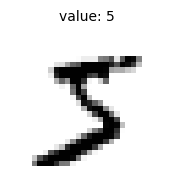

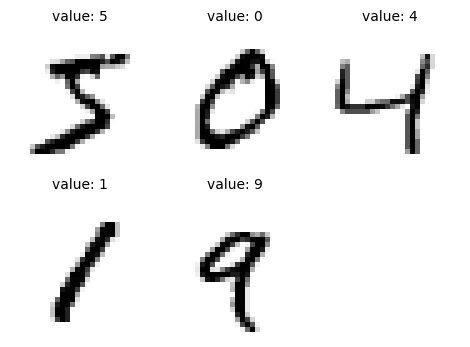

In [ ]:
display(show_image(images[0], {"value": digits[0]}))
display(show_image_table(images[:5], {"value": digits[:5]}, cols=3))

In [ ]:
images_train = images[:60000]
digits_train = digits[:60000]

images_test = images[60000:]
digits_test = digits[60000:]

Question: Is it really sufficient to just randomly sort the data? Think about how this data has been created and which biases could be introduced.

 I think no it won't be good to just randomley sort the data. since If it was collected in a way that introduces patterns or biases, random sorting might not eliminate these biases. but only make it more.

In [ ]:
def confusion_data(true, pred, labels=None, title=None):
    """
    Compute the confusion matrix and create a figure.

    The axes labels can be changed if needed, and a title can be added.
    """

    cm = confusion_matrix(true, pred)

    fig, ax = plt.subplots()
    cm_display = ConfusionMatrixDisplay(cm)
    cm_display.plot(ax=ax, cmap=plt.cm.Blues)

    if labels is None:
        labels = ("true", "predicted")

    ax.set_ylabel(labels[0])
    ax.set_xlabel(labels[1])

    if title is not None:
        ax.set_title(title)

    plt.close()

    return cm, fig

In [ ]:
lin_cls = LogisticRegression(C=1.0)
lin_cls.fit(images_train, digits_train)

pred_train = lin_cls.predict(images_train)
pred_test = lin_cls.predict(images_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Accuracy:
- train set: 93.51%
- test set: 92.58%



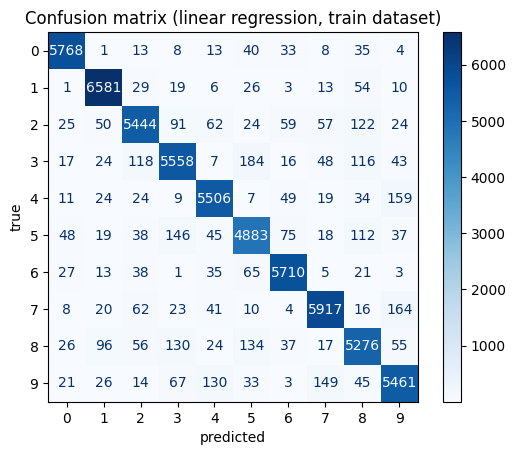

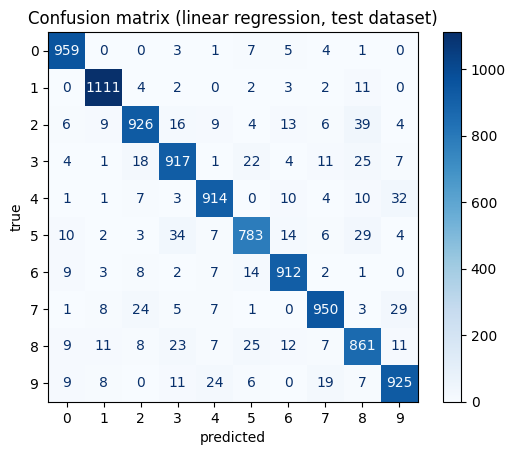

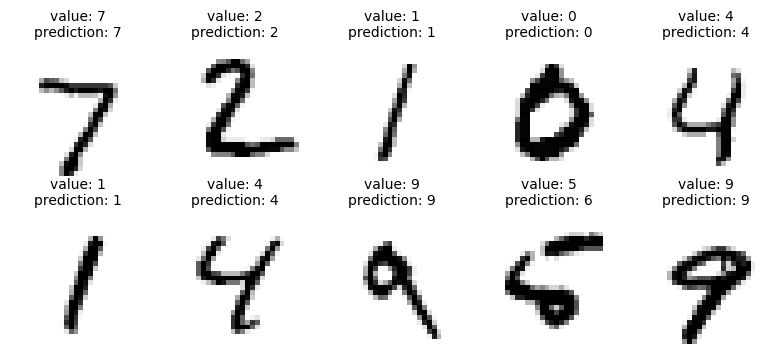

In [ ]:
acc_train = accuracy_score(digits_train, pred_train)
acc_test = accuracy_score(digits_test, pred_test)

print(f"""
Accuracy:
- train set: {acc_train:.2%}
- test set: {acc_test:.2%}
"""
)

cm_train, fig_train = confusion_data(
    digits_train,
    pred_train,
    title="Confusion matrix (linear regression, train dataset)",
)
cm_test, fig_test = confusion_data(
    digits_test, pred_test, title="Confusion matrix (linear regression, test dataset)"
)

display(fig_train, fig_test)

show_image_table(
    images_test[:10],
    labels={"value": digits_test[:10], "prediction": pred_test[:10]},
    cols=5,
)

**Question:** Play with the parameter $C$ to see the effect on the accuracy (but the default value gives already the best result).

Ans:

Results for C = 0.01:

Accuracy:
- train set: 91.86%
- test set: 91.87%



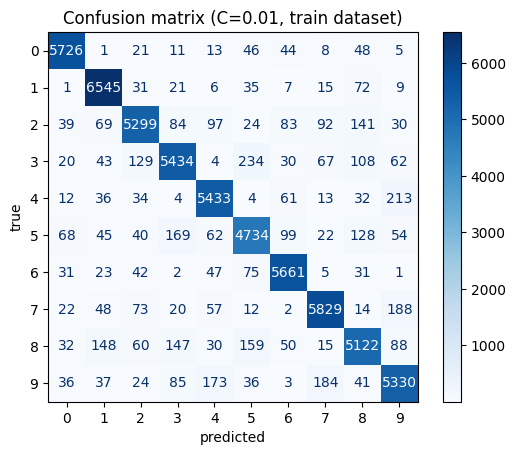

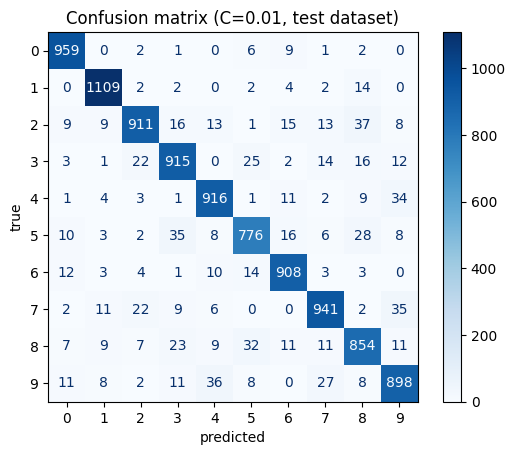

Results for C = 0.1:

Accuracy:
- train set: 93.22%
- test set: 92.58%



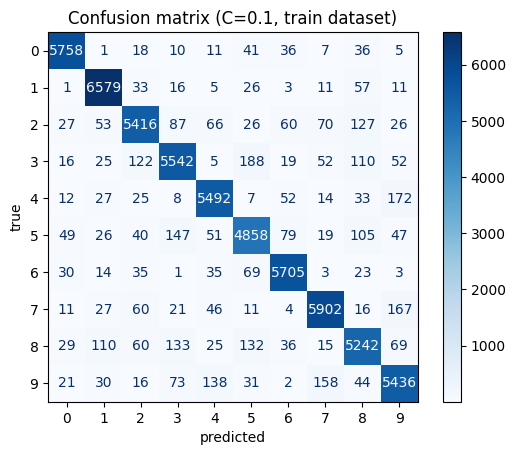

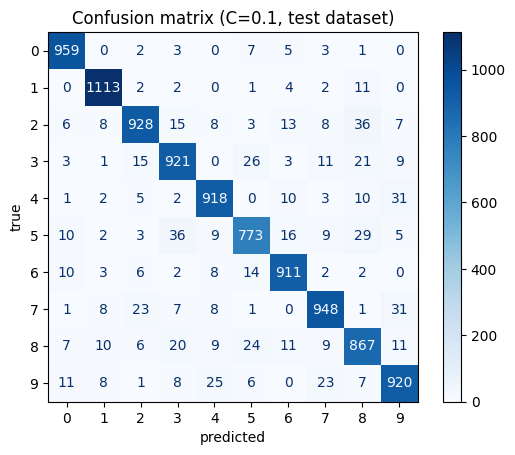

Results for C = 1.0:

Accuracy:
- train set: 93.93%
- test set: 92.56%



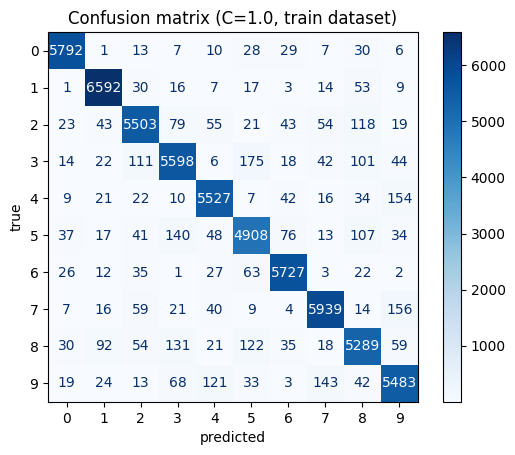

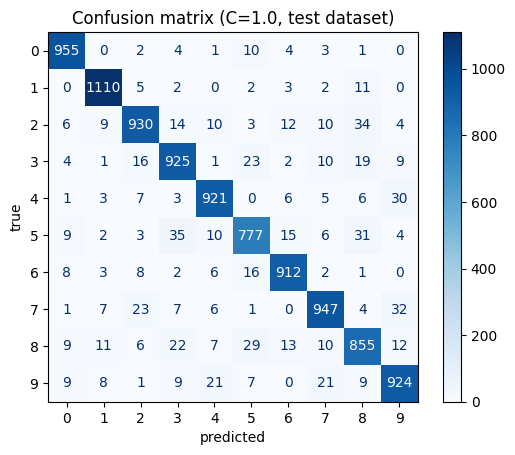

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Results for C = 10:

Accuracy:
- train set: 94.23%
- test set: 92.39%



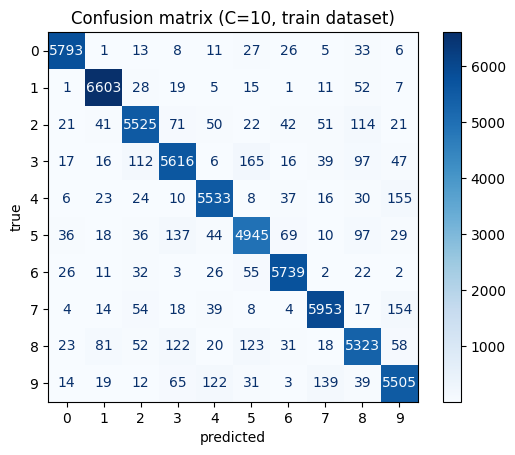

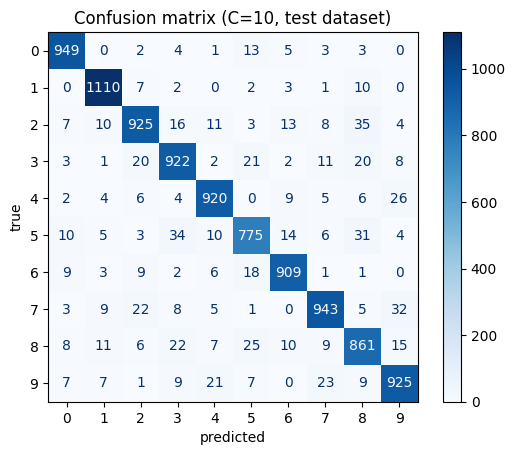

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Results for C = 100:

Accuracy:
- train set: 94.30%
- test set: 92.26%



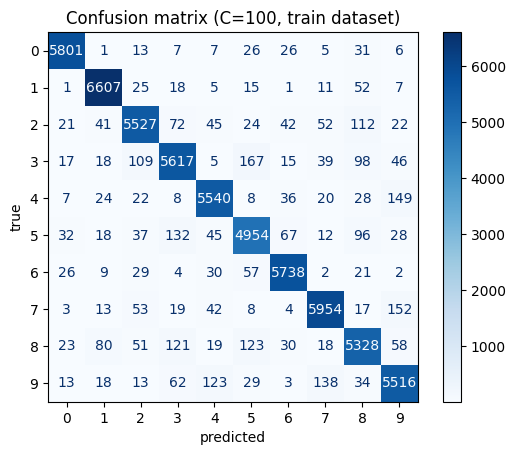

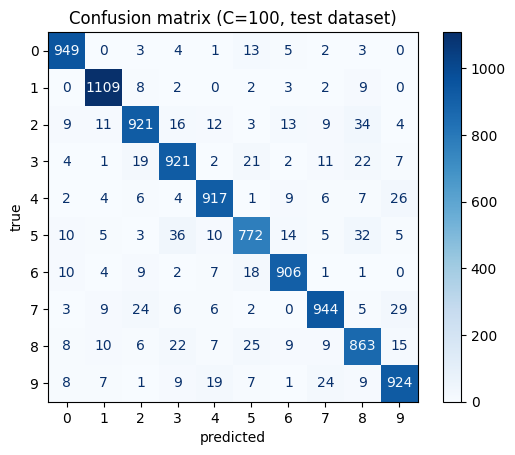

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Define a list of C values to test
C_values = [0.01, 0.1, 1.0, 10, 100]

for C in C_values:
    # Train the logistic regression model with current C
    lin_cls = LogisticRegression(C=C, max_iter=1000)
    lin_cls.fit(images_train, digits_train)

    # predictions
    pred_train = lin_cls.predict(images_train)
    pred_test = lin_cls.predict(images_test)

    # accuracy
    acc_train = accuracy_score(digits_train, pred_train)
    acc_test = accuracy_score(digits_test, pred_test)

    # Display results
    print(f"Results for C = {C}:")
    print(f"""
Accuracy:
- train set: {acc_train:.2%}
- test set: {acc_test:.2%}
"""
)

    # to plot confusion matrices
    cm_train, fig_train = confusion_data(
        digits_train,
        pred_train,
        title=f"Confusion matrix (C={C}, train dataset)",
    )
    cm_test, fig_test = confusion_data(
        digits_test, pred_test, title=f"Confusion matrix (C={C}, test dataset)"
    )

    display(fig_train, fig_test)

    # display example images
    show_image_table(
        images_test[:10],
        labels={"value": digits_test[:10], "prediction": pred_test[:10]},
        cols=5,
    )


Question 1: Create and Evaluate a Basic MLPClassifier
Create an MLPClassifier with a single hidden layer of 50 neurons and use the solver sgd. Set max_iter to 10 for quick training. Then, train the network, make predictions, compute accuracy, and generate the confusion matrix. Finally, display the first 15 images from the test set with their predictions.

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



Accuracy:
- train set: 90.72%
- test set: 91.02%



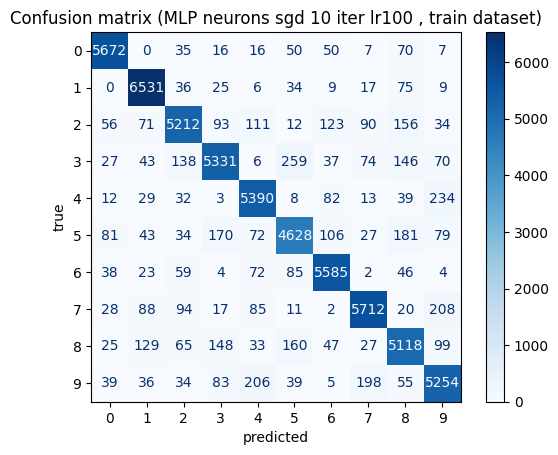

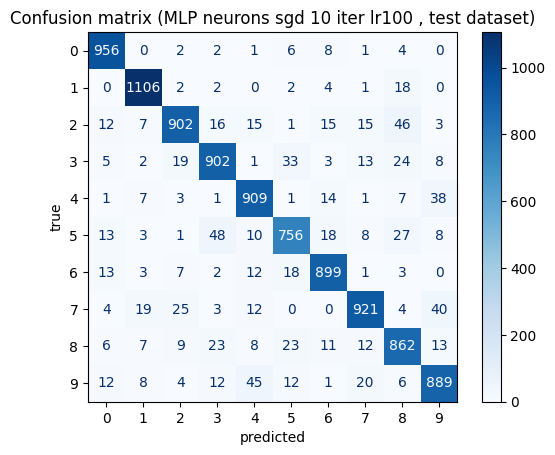

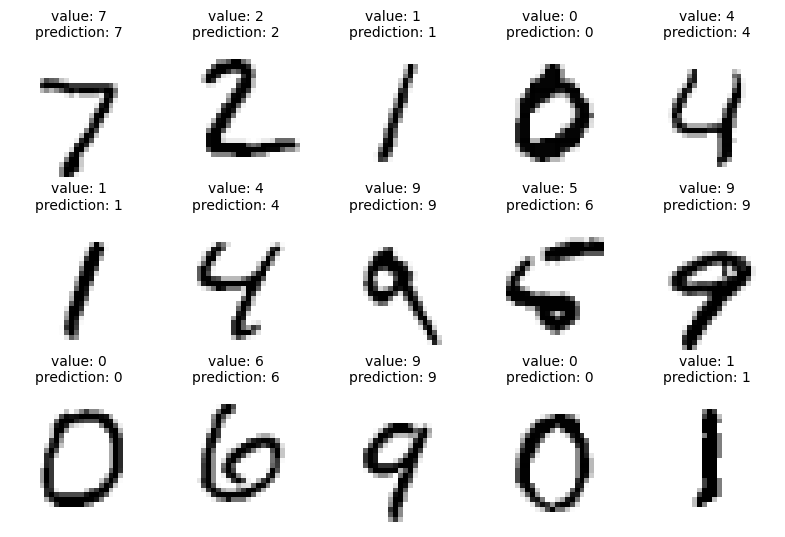

In [ ]:
# Define the MLPClassifier with 50 neurons in the hidden layer and solver 'sgd'
# random_state = seed = learning rate = 100
lr=seed
mlp = MLPClassifier(hidden_layer_sizes=(50,), solver='sgd', max_iter=10, random_state=seed)
mlp.fit(images_train, digits_train)

# Make predictions
pred_train = mlp.predict(images_train)
pred_test = mlp.predict(images_test)

# Compute accuracy
acc_train = accuracy_score(digits_train, pred_train)
acc_test = accuracy_score(digits_test, pred_test)

# Print results
print(f"""
Accuracy:
- train set: {acc_train:.2%}
- test set: {acc_test:.2%}
"""
)
fig_title= f'MLP neurons sgd 10 iter lr{lr} '

# Generate confusion matrices
cm_train, fig_train = confusion_data(
    digits_train,
    pred_train,
    title=f"Confusion matrix ({fig_title}, train dataset)",
)
cm_test, fig_test = confusion_data(
    digits_test, pred_test, title=f"Confusion matrix ({fig_title}, test dataset)"
)

# Display confusion matrices
display(fig_train, fig_test)

# Display the first 15 test images with labels and predictions
show_image_table(
    images_test[:15],
    labels={"value": digits_test[:15], "prediction": pred_test[:15]},
    cols=5
)

Question 2: Tune learning_rate_init
Add the learning_rate_init parameter and experiment with different values to see how it affects the accuracy.

Learning rate = 0.001:
  - Test set accuracy: 97.45%


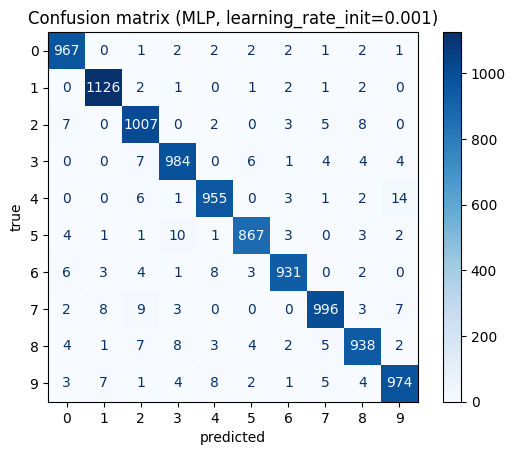

Learning rate = 0.01:
  - Test set accuracy: 97.34%


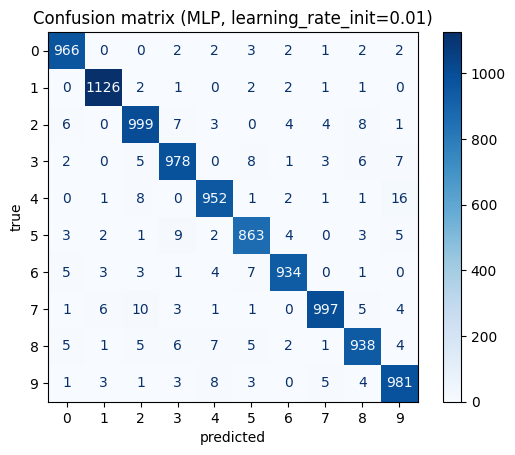

In [ ]:
# List of learning rates to try
learning_rates = [0.001, 0.01]

for lr in learning_rates:
    mlp = MLPClassifier(hidden_layer_sizes=(50,), solver='sgd', max_iter=1000, learning_rate_init=lr, random_state=seed)
    mlp.fit(images_train, digits_train)

    # Make predictions
    pred_test = mlp.predict(images_test)
    pred_train = mlp.predict(images_train)

    # Compute accuracy
    acc_test = accuracy_score(digits_test, pred_test)
    acc_train = accuracy_score(digits_train, pred_train)

    # Print results
    print(f"Learning rate = {lr}:")
    print(f"  - Test set accuracy: {acc_test:.2%}")

    # Display confusion matrix
    cm_test, fig_test = confusion_data(
        digits_test, pred_test, title=f"Confusion matrix (MLP, learning_rate_init={lr})"
    )
    display(fig_test)


Question 3: Experiment with Hidden Layer Sizes
Play with different sizes for the hidden layers and find parameters that correctly predict the 9th image from the test set.

In [ ]:
# List of hidden layer sizes to try
hidden_layer_sizes_list = [(50,), (100,), (50, 50), (100, 100)]

for sizes in hidden_layer_sizes_list:
    mlp = MLPClassifier(hidden_layer_sizes=sizes, solver='sgd', max_iter=1000, random_state=seed)
    mlp.fit(images_train, digits_train)

    # Make predictions
    pred_test = mlp.predict(images_test)

    # Check prediction for the 9th image
    if pred_test[9] == digits_test[9]:
        print(f"Hidden layer sizes {sizes} correctly predicted the 9th image.")
        break

    # Display confusion matrix
    cm_test, fig_test = confusion_data(
        digits_test, pred_test, title=f"Confusion matrix (MLP, hidden_layer_sizes={sizes})"
    )
    display(fig_test)


Hidden layer sizes (50,) correctly predicted the 9th image.



Question: Train a `LogisticRegression` and a `MLPClassifier`. In both cases, compute the accuracy and confusion matrix.


Accuracy with PCA components:
- train set: 92.20%
- test set: 92.10%



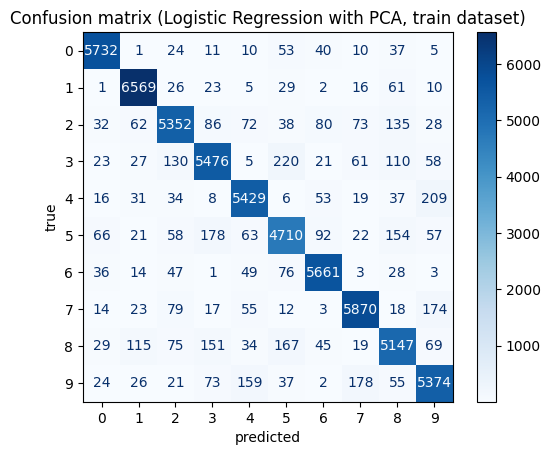

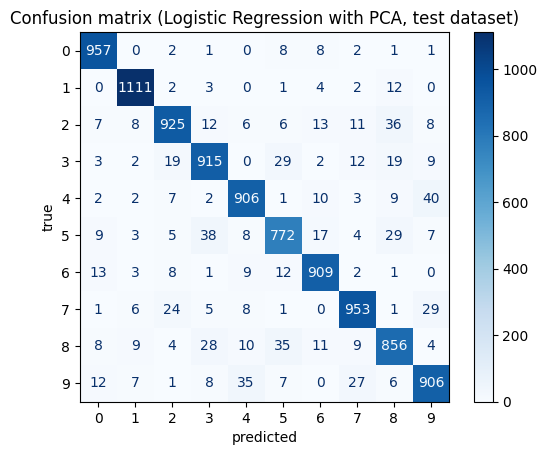


Accuracy with PCA components (MLPClassifier):
- train set: 98.38%
- test set: 97.30%



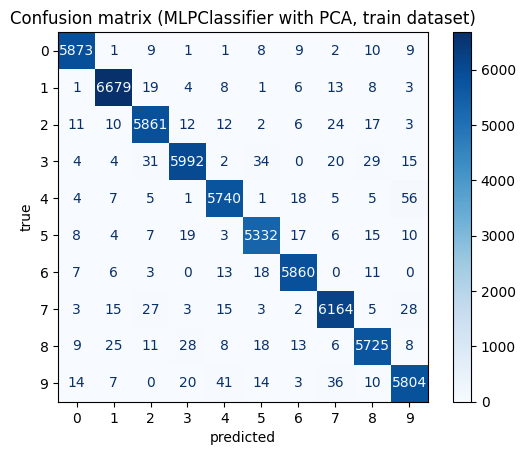

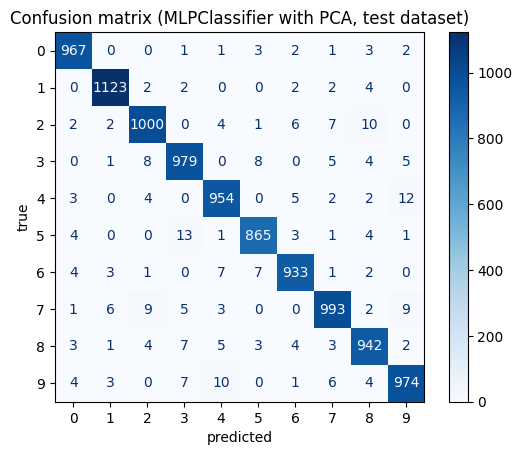

In [ ]:
# 1st: Perform PCA with 100 components
n_pca = 100
pca = PCA(n_components=n_pca)
pca.fit(images_train)

images_train_pca = pca.transform(images_train)
images_test_pca = pca.transform(images_test)

# 2nd: Train Logistic Regression
lin_cls_pca = LogisticRegression(max_iter=1000)  # Ensure max_iter is large enough for convergence
lin_cls_pca.fit(images_train_pca, digits_train)

# Predict and evaluate Logistic Regression
pred_train_pca = lin_cls_pca.predict(images_train_pca)
pred_test_pca = lin_cls_pca.predict(images_test_pca)

# Compute accuracy
acc_train_pca = accuracy_score(digits_train, pred_train_pca)
acc_test_pca = accuracy_score(digits_test, pred_test_pca)

print(f"""
Accuracy with PCA components:
- train set: {acc_train_pca:.2%}
- test set: {acc_test_pca:.2%}
"""
)

# Compute and display confusion matrix for Logistic Regression
cm_train_pca, fig_train_pca = confusion_data(
    digits_train,
    pred_train_pca,
    title="Confusion matrix (Logistic Regression with PCA, train dataset)"
)
cm_test_pca, fig_test_pca = confusion_data(
    digits_test, pred_test_pca, title="Confusion matrix (Logistic Regression with PCA, test dataset)"
)

display(fig_train_pca, fig_test_pca)

# 3ed: Train MLPClassifier
# nureons = hidden_layer_sizes= 50
mlp_cls_pca = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, solver='sgd', random_state=100)
mlp_cls_pca.fit(images_train_pca, digits_train)

# Predict and evaluate MLPClassifier
pred_train_mlp_pca = mlp_cls_pca.predict(images_train_pca)
pred_test_mlp_pca = mlp_cls_pca.predict(images_test_pca)

# Compute accuracy
acc_train_mlp_pca = accuracy_score(digits_train, pred_train_mlp_pca)
acc_test_mlp_pca = accuracy_score(digits_test, pred_test_mlp_pca)

print(f"""
Accuracy with PCA components (MLPClassifier):
- train set: {acc_train_mlp_pca:.2%}
- test set: {acc_test_mlp_pca:.2%}
"""
)

# Compute and display confusion matrix for MLPClassifier
cm_train_mlp_pca, fig_train_mlp_pca = confusion_data(
    digits_train,
    pred_train_mlp_pca,
    title="Confusion matrix (MLPClassifier with PCA, train dataset)"
)
cm_test_mlp_pca, fig_test_mlp_pca = confusion_data(
    digits_test, pred_test_mlp_pca, title="Confusion matrix (MLPClassifier with PCA, test dataset)"
)

display(fig_train_mlp_pca, fig_test_mlp_pca)

Question: Redo the k-means analysis from above with the PCA data (keep only 100 components). Show the confusion matrix. Do a scatter plot for the cluster assignment of the first 2 PCA components, and compare with the previous scatter plot.

In [ ]:
# Standardize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
images_train_scaled = scaler.fit_transform(images_train)
images_test_scaled = scaler.transform(images_test)

# Apply PCA
pca = PCA(n_components=100)
images_train_pca = pca.fit_transform(images_train_scaled)
images_test_pca = pca.transform(images_test_scaled)


In [ ]:
n_clusters = 10

# K-means clustering on PCA data
kmeans_pca = KMeans(n_clusters=n_clusters, n_init="auto")
kmeans_pca.fit(images_train_pca)

kmeans_train_pca = kmeans_pca.predict(images_train_pca)
kmeans_test_pca = kmeans_pca.predict(images_test_pca)

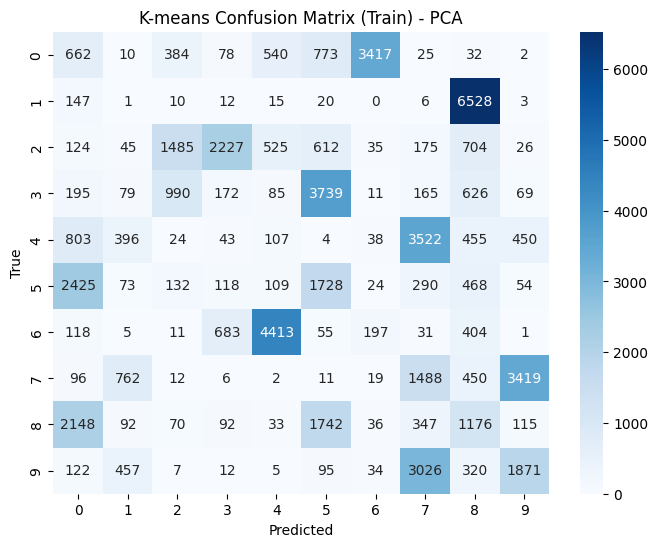

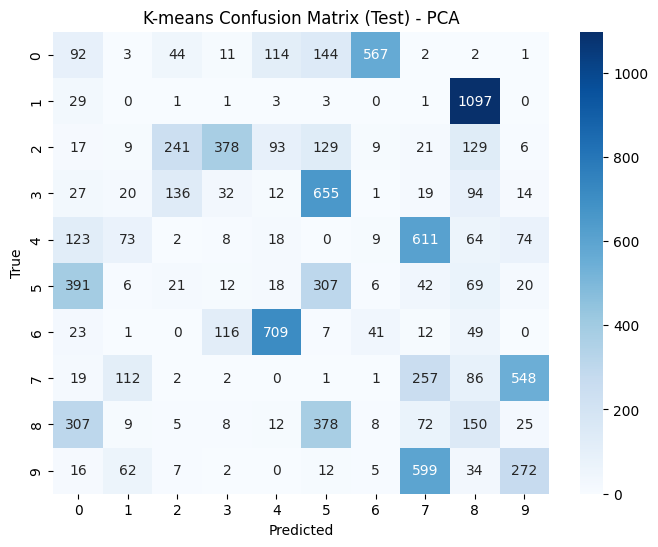

In [ ]:
import seaborn as sns

def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Confusion matrix for training set
cm_train_pca = confusion_matrix(digits_train, kmeans_train_pca)
plot_confusion_matrix(cm_train_pca, labels=range(n_clusters), title="K-means Confusion Matrix (Train) - PCA")

# Confusion matrix for test set
cm_test_pca = confusion_matrix(digits_test, kmeans_test_pca)
plot_confusion_matrix(cm_test_pca, labels=range(n_clusters), title="K-means Confusion Matrix (Test) - PCA")


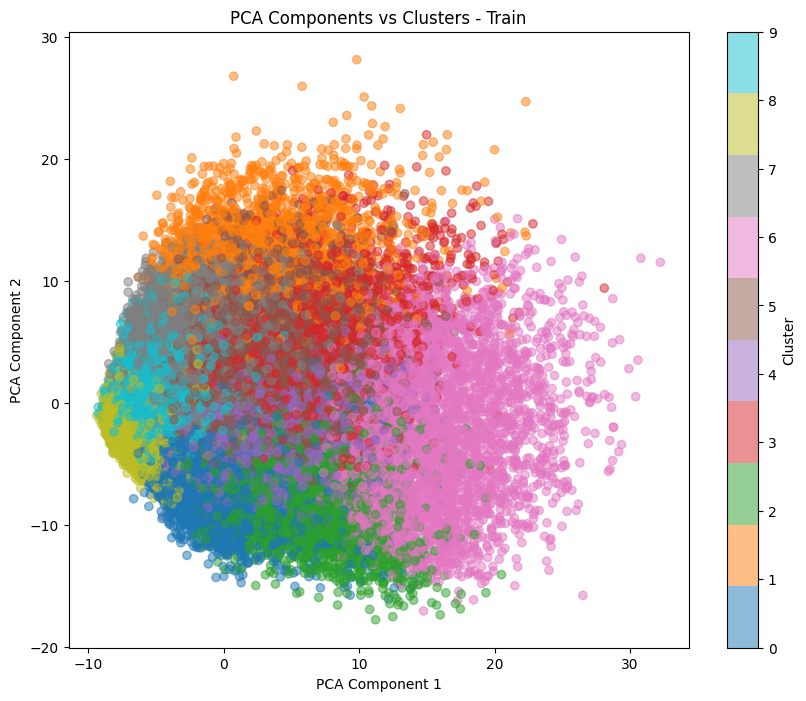

In [ ]:
def scatter_pca_clusters(X, labels, title):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="tab10", alpha=0.5)
    plt.colorbar(scatter, label="Cluster")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title(title)
    plt.show()

# Plot clusters for PCA-reduced data
scatter_pca_clusters(images_train_pca[:, :2], kmeans_train_pca, "PCA Components vs Clusters - Train")

In [ ]:
class AutoEncoder(nnx.Module):
    def __init__(self, hidden_dim, latent_dim, rngs):
        self.hidden_in = nnx.Linear(784, hidden_dim, rngs=rngs)
        self.latent = nnx.Linear(hidden_dim, latent_dim, rngs=rngs)
        self.hidden_out = nnx.Linear(latent_dim, hidden_dim, rngs=rngs)
        self.reconstruction = nnx.Linear(hidden_dim, 784, rngs=rngs)

    def __call__(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def encode(self, x):
        x = nnx.relu(self.hidden_in(x))
        x = nnx.relu(self.latent(x))
        return x

    def decode(self, x):
        x = nnx.relu(self.hidden_out(x))
        x = nnx.sigmoid(self.reconstruction(x))
        return x


In [ ]:
def loss_fn(model, batch):
    results = model(batch)
    loss = jnp.mean((results - batch) ** 2)
    return loss, results

@nnx.jit
def train_step(model, optimizer, metrics, batch):
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, results), grads = grad_fn(model, batch)
    optimizer.update(grads)
    metrics.update(loss=loss)

@nnx.jit
def eval_step(model, metrics, batch):
    loss, results = loss_fn(model, batch)
    metrics.update(loss=loss)


In [ ]:
def training(model, optimizer, images, epochs=5, batch_size=64):
    metrics = nnx.metrics.Average("loss")
    metrics_history = {"train_loss": [], "val_loss": []}
    batch_steps = len(images) // batch_size

    for n_epoch in range(1, epochs + 1):
        batch_data = rng.permutation(images)[: batch_steps * batch_size].reshape(batch_size, batch_steps, 784)

        for batch in batch_data:
            train_step(model, optimizer, metrics, batch)

        metrics_history["train_loss"].append(metrics.compute())
        metrics.reset()
        eval_step(model, metrics, images_test)
        metrics_history["val_loss"].append(metrics.compute())
        metrics.reset()

        if n_epoch % 2 == 0:
            print(
                "[train]",
                f"Epoch {n_epoch},",
                f"Loss: {metrics_history['train_loss'][-1]:.4g}",
            )
            print(
                "[test]".rjust(7),
                f"Epoch {n_epoch},",
                f"Loss: {metrics_history['val_loss'][-1]:.4g}",
            )

    return metrics, metrics_history


In [ ]:
hidden_dim = 50
latent_dim = 3
autoencoder = AutoEncoder(hidden_dim=hidden_dim, latent_dim=latent_dim, rngs=nnx.Rngs(0))

learning_rate = 0.005
momentum = 0.9
optimizer = nnx.Optimizer(autoencoder, optax.adam(learning_rate))

epochs = 20
batch_size = 64

metrics, metrics_history = training(autoencoder, optimizer, images, epochs, batch_size)


[train] Epoch 2, Loss: 0.06213
 [test] Epoch 2, Loss: 0.05759
[train] Epoch 4, Loss: 0.04895
 [test] Epoch 4, Loss: 0.04715
[train] Epoch 6, Loss: 0.04456
 [test] Epoch 6, Loss: 0.04357
[train] Epoch 8, Loss: 0.04204
 [test] Epoch 8, Loss: 0.04142
[train] Epoch 10, Loss: 0.04085
 [test] Epoch 10, Loss: 0.04032
[train] Epoch 12, Loss: 0.04013
 [test] Epoch 12, Loss: 0.03969
[train] Epoch 14, Loss: 0.03972
 [test] Epoch 14, Loss: 0.03931
[train] Epoch 16, Loss: 0.03935
 [test] Epoch 16, Loss: 0.03904
[train] Epoch 18, Loss: 0.03905
 [test] Epoch 18, Loss: 0.03868
[train] Epoch 20, Loss: 0.03877
 [test] Epoch 20, Loss: 0.03842


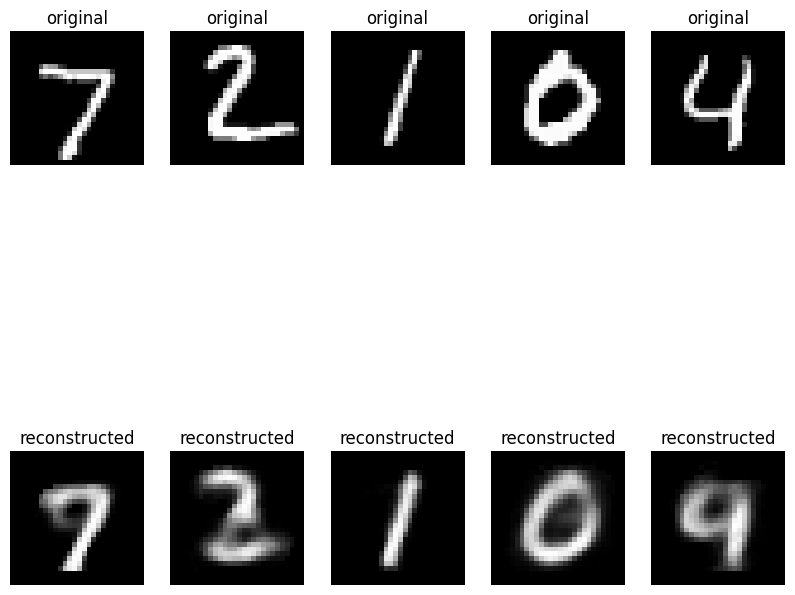

None

In [ ]:
cols = 5
reconstructed = autoencoder(images_test[:cols])

# Function to display images
def show_image_table(images, labels=None, cols=7):
    rows = (len(images) + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(10, 10))
    for i, ax in enumerate(axs.flat):
        if i < len(images):
            ax.imshow(images[i].reshape(28, 28), cmap='gray')  # Ensure images are reshaped
            if labels is not None:
                ax.set_title(labels[i])
        ax.axis('off')
    plt.show()

original_images = images_test[:cols].reshape(cols, 28, 28)
reconstructed_images = jax.device_get(reconstructed).reshape(cols, 28, 28)

display(
    show_image_table(
        np.concatenate((original_images, reconstructed_images)),
        labels=np.ravel([["original"] * cols, ["reconstructed"] * cols]),
        cols=cols,
    )
)

Question: Generate different numbers.

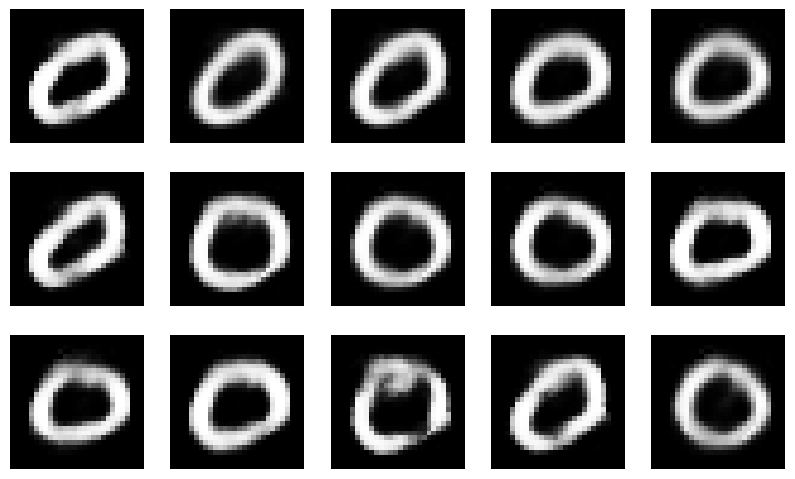

In [ ]:
def generate_digits(latent_dim, n_samples=10):
    # Sample random points in the latent space
    latent_samples = np.random.uniform(-1, 1, size=(n_samples, latent_dim))

    # Generate images from the sampled latent vectors
    generated_images = autoencoder.decode(jnp.array(latent_samples))

    # Convert the generated images to numpy arrays and rescale to [0, 1]
    generated_images = np.clip(np.array(generated_images), 0, 1)

    return generated_images

def display_generated_images(images, n_cols=5):
    n_images = len(images)
    n_rows = (n_images + n_cols - 1) // n_cols

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

    for i, ax in enumerate(axs.flat):
        if i < n_images:
            ax.imshow(images[i].reshape(28, 28), cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')

    plt.show()

# Generate digits from random latent space samples
latent_dim = 3
generated_images = generate_digits(latent_dim, n_samples=15)

# Display the generated images
display_generated_images(generated_images, n_cols=5)


Question: Add the noise below to an image, then apply the autoencoder and display both results for comparison.

noise = 0.1 * np.abs(rng.normal(0, 0.3, 784))

In [ ]:
noise = 0.1 * np.abs(rng.normal(0, 0.3, 784))

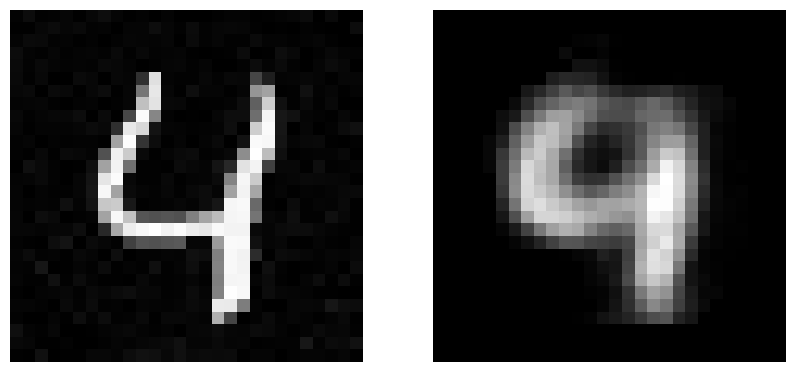

In [ ]:
original_image = images_test[4]

#add noise
img_noise= original_image + noise

#add autoencoder
AE_img_noise= autoencoder(img_noise)

img_table=(img_noise, AE_img_noise)
show_image_table(img_table, labels=None, cols=2)

Question: Apply the autoencoder to the brontosaurus image. What do you observe?


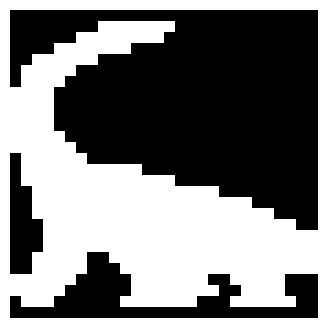

None

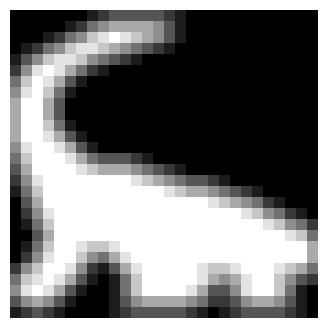

None

In [ ]:
brontosaurus_img = np.array(
      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

display(show_image(brontosaurus_img))

# the original image is binary, so we yse a convolution to convert it to gray scale
psf = np.ones((3, 3)) / 25
img_conv = convolve2d(brontosaurus_img.reshape(28, 28), psf, 'same').flatten()
brontosaurus_img = img_conv / np.max(img_conv)

display(show_image(brontosaurus_img))


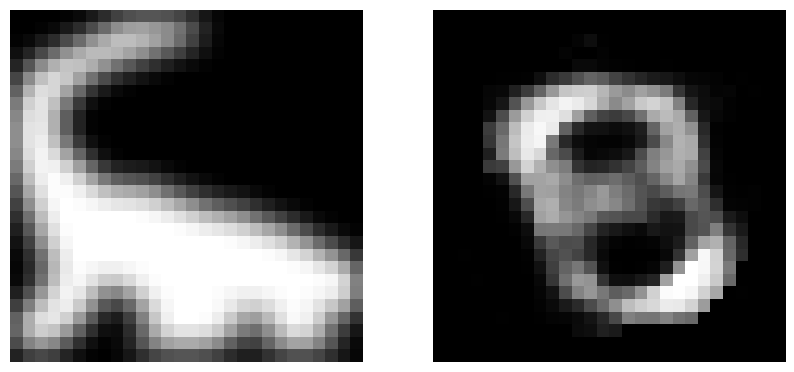

In [ ]:
#add autoencoder
AE_brontosaurus_img= autoencoder(brontosaurus_img)

img_table=(brontosaurus_img, AE_brontosaurus_img)
show_image_table(img_table, labels=None, cols=2)

Question: Use the mse() function to compare the values for the train set, test set, and for the brontosaurus image. What do you observe?

You can use a histogram to display the distributions of the MSE for the train and test sets. You can add a line for the brontosaurus using ax.axvline().

In [ ]:
def mse(images):
    return np.average((images - autoencoder(images)) ** 2, axis=-1)

In [ ]:
# Compute MSE for train and test sets
mse_train = mse(images_train)
mse_test = mse(images_test)

# Compute MSE for the brontosaurus image
mse_brontosaurus = mse(np.array([brontosaurus_img]))

mse_train,mse_test,mse_brontosaurus

(array([0.04914559, 0.02324227, 0.05764885, ..., 0.05160332, 0.04452713,
        0.04214808], dtype=float32),
 array([0.02999617, 0.05611599, 0.00834277, ..., 0.03398637, 0.04967266,
        0.04616424], dtype=float32),
 array([0.26648903], dtype=float32))

In [ ]:
mse_train.shape

(60000,)

<Figure size 1200x600 with 0 Axes>

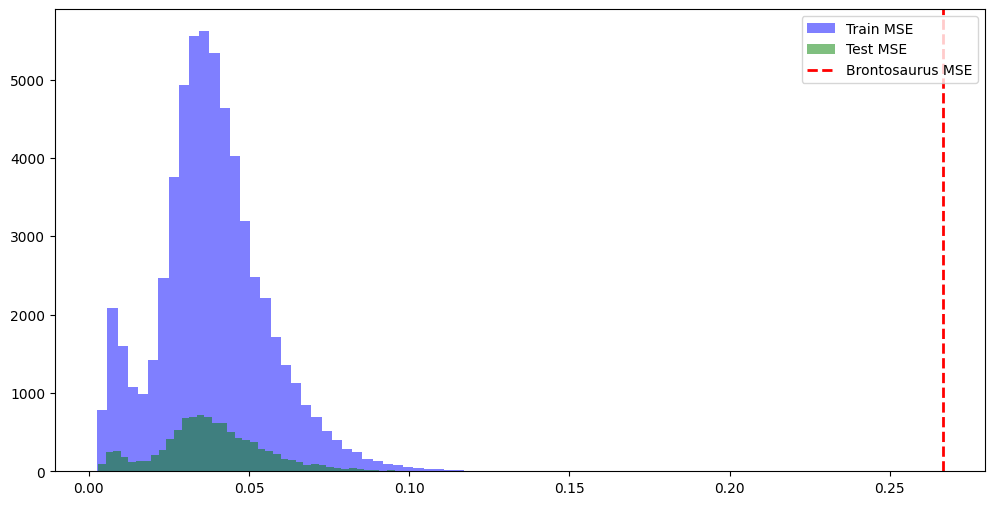

In [ ]:
x=mse_train
y=mse_test
z=mse_brontosaurus

# Plot histograms for train and test MSE distributions
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(x, bins=50, alpha=0.5, label='Train MSE', color='blue')
ax.hist(y, bins=50, alpha=0.5, label='Test MSE', color='green')

# Add a vertical line for the brontosaurus MSE
ax.axvline(z, color='red', linestyle='dashed', linewidth=2, label='Brontosaurus MSE')

ax.legend(loc='upper right')

# Display the plot
plt.show()

In [ ]:
def is_anomaly(images):
    ref_mse = mse(images_train)
    mse_min = np.min(ref_mse)
    mse_max = np.max(ref_mse)

    ratios = (mse(images) - mse_min) / (mse_max - mse_min)

    return ratios > 1


display_markdown(f"""
Anomalies:
- train set: {is_anomaly(images_train).any()}
- test set: {is_anomaly(images_test).any()}
- brontosaurus: {is_anomaly(brontosaurus_img)}
""",
    raw=True,
)


Anomalies:
- train set: False
- test set: False
- brontosaurus: True
